## System steup

In [29]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float

In [30]:
domain = '7JJK'
ref_pdb = f'/workspace7/torchmd-AD/crystals_dataset/pdb_data/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/crystals_dataset/topology_data/{domain}.psf'

ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')
ref_mol.read(ref_psf)

mol = ref_mol

2022-02-23 13:58:22,430 - moleculekit.molecule - WARNING - Alternative atom locations detected. Only altloc A was kept. If you prefer to keep all use the keepaltloc="all" option when reading the file.
2022-02-23 13:58:22,433 - moleculekit.molecule - INFO - Removed 11 atoms. 1199 atoms remaining in the molecule.
2022-02-23 13:58:22,449 - moleculekit.molecule - INFO - Removed 1128 atoms. 71 atoms remaining in the molecule.


In [31]:
native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)

print('Starting rmsd: ', rmsd(coords, native_coords))

Starting rmsd:  tensor(0.0062, device='cuda:0')


In [32]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [33]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))

In [34]:
get_embeddings(mol, 'cpu', 1)

tensor([[ 2, 11, 14, 19, 18,  8, 15,  9,  1,  3, 15, 14,  7,  1, 18, 21, 11, 18,
          8,  1, 20,  1, 19,  1,  9,  8,  1,  1,  9,  9,  1,  6, 21, 12, 14, 10,
         20,  2, 20,  6,  7,  9, 19, 20, 12,  6,  6, 10, 19, 19,  8,  4,  4,  5,
          6,  1, 10, 19, 21, 19,  6, 19, 11, 18,  6,  6,  3,  8,  2,  7, 14]])

In [35]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/repo/torchmd-exp/scripts/trainings/tests/test_cath/cath_128_levels/dih_general_tm_0.6/'
nnp += 'epoch=1233-train_loss=1.0127-val_loss=0.6081.ckpt'
embeddings = torch.tensor([ 2, 11, 14, 19, 18,  8, 15,  9,  1,  3, 15, 14,  7,  1, 18, 21, 11, 18,
          8,  1, 20,  1, 19,  1,  9,  8,  1,  1,  9,  9,  1,  6, 21, 12, 14, 10,
         20,  2, 20,  6,  7,  9, 19, 20, 12,  6,  6, 10, 19, 19,  8,  4,  4,  5,
          6,  1, 10, 19, 21, 19,  6, 19, 11, 18,  6,  6,  3,  8,  2,  7, 14]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [36]:
from torchmd.forces import Forces
external=None
forces = Forces(parameters,terms=['bonds', 'repulsioncg', 'dihedrals'], cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)

[88.42882919311523]


## Dynamics

In [37]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 550  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)

 32%|██████████▌                      | 1607/5000 [23:56<50:33,  1.12it/s]


KeyboardInterrupt: 

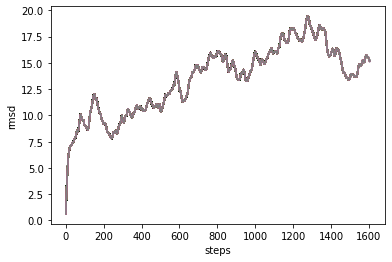

In [38]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 20
save_period = 20
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    wrapper.wrap(system.pos, system.box)
    currpos = system.pos.detach().cpu().numpy().copy()
    traj.append(currpos)

    rmsds.append(rmsd(system.pos, native_coords).item())
    Ep.append(Epot)
    
    if rmsds[-1] > 40:
        break
    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [40]:
import copy
tmp_mol = copy.deepcopy(mol)
mol_xtc = Molecule(ref_psf)
rmsd_proj = MetricRmsd(ref_mol, 'name CA', centerstr='name CA', pbc=False)
rmsd_range = [0,2]
for conf in traj:
    tmp_mol.coords = np.moveaxis(conf, 0, -1)
    tmp_mol.align('name CA', refmol=ref_mol)
    rmsd_value = rmsd_proj.project(tmp_mol)
    
    if rmsd_range[0] <= rmsd_value.item() <= rmsd_range[1]:
        print(rmsd_value)
        mol_xtc.appendFrames(tmp_mol)
        rmsd_range = [ x + 2.5 for x in rmsd_range]
    

0.62261206
2.8299909
5.1161256
7.5098476
10.002203
12.504479
15.03603
17.523277


In [41]:
mol_xtc.box = np.zeros(shape=(3,mol_xtc.numFrames), dtype=np.float32)
mol_xtc.write(f'/workspace7/torchmd-AD/crystals_dataset/xtc_data/{domain}_kcenters_8clusters.xtc')